## We'll check if we understand well amico's variables

In [1]:
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances



In [2]:
inpath = '/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/amico/map_detections_refined_noBuffer_all.fits'

In [3]:
amico_data = Table.read(inpath) 

In [4]:
print(amico_data.colnames)

['ID', 'Xpix', 'Ypix', 'Zpix', 'Xphys', 'Yphys', 'Zphys', 'SN', 'SN_NO_CLUSTER', 'AMP', 'RICH', 'LIKE', 'MSKFRC', 'POISS', 'LAMB', 'LAMBSTAR', 'Zpix_sigm', 'Zpix_sigp', 'Zphys_sigm', 'Zphys_sigp', 'Pz-0', 'Pz-1', 'Pz-2', 'Pz-3', 'Pz-4', 'Pz-5', 'Pz-6', 'Pz-7', 'Pz-8', 'Pz-9', 'Pz-10', 'Pz-11', 'Pz-12', 'Pz-13', 'Pz-14', 'Pz-15', 'Pz-16', 'Pz-17', 'Pz-18', 'Pz-19', 'Pz-20', 'Pz-21', 'Pz-22', 'Pz-23', 'Pz-24', 'Pz-25', 'Pz-26', 'Pz-27', 'Pz-28', 'Pz-29', 'Pz-30', 'Pz-31', 'Pz-32', 'Pz-33', 'Pz-34', 'Pz-35', 'Pz-36', 'Pz-37', 'Pz-38', 'Pz-39', 'Pz-40', 'Pz-41', 'Pz-42', 'Pz-43', 'Pz-44', 'Pz-45', 'Pz-46', 'Pz-47', 'Pz-48', 'Pz-49', 'Pz-50', 'Pz-51', 'Pz-52', 'Pz-53', 'Pz-54', 'Pz-55', 'Pz-56', 'Pz-57', 'Pz-58', 'Pz-59', 'Pz-60', 'Pz-61', 'Pz-62', 'Pz-63', 'Pz-64', 'Pz-65', 'Pz-66', 'Pz-67', 'Pz-68', 'Pz-69', 'Pz-70', 'Pz-71', 'Pz-72', 'Pz-73', 'Pz-74', 'Pz-75', 'Pz-76', 'Pz-77', 'Pz-78', 'Pz-79', 'Pz-80', 'Pz-81', 'Pz-82', 'Pz-83', 'Pz-84', 'Pz-85', 'Pz-86', 'Pz-87', 'Pz-88', 'Pz-89', 'Pz

In [5]:
print("Number of AMICO clusters = ", len(amico_data))

Number of AMICO clusters =  11485


In [6]:
amico_data_df = amico_data.to_pandas()
type(amico_data_df)

pandas.core.frame.DataFrame

Text(0, 0.5, 'dec')

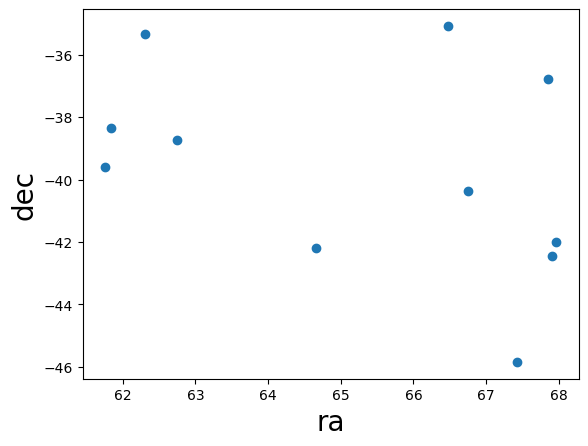

In [12]:
amico_cl = amico_data[amico_data['ID']==7]
plt.scatter(amico_cl['Xphys'], amico_cl['Yphys'])
plt.xlabel('ra', fontsize = 20)
plt.ylabel('dec', fontsize = 20)

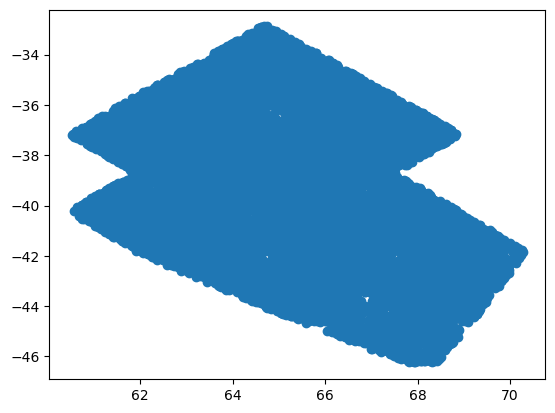

In [13]:
plt.scatter(amico_data['Xphys'], amico_data['Yphys'])

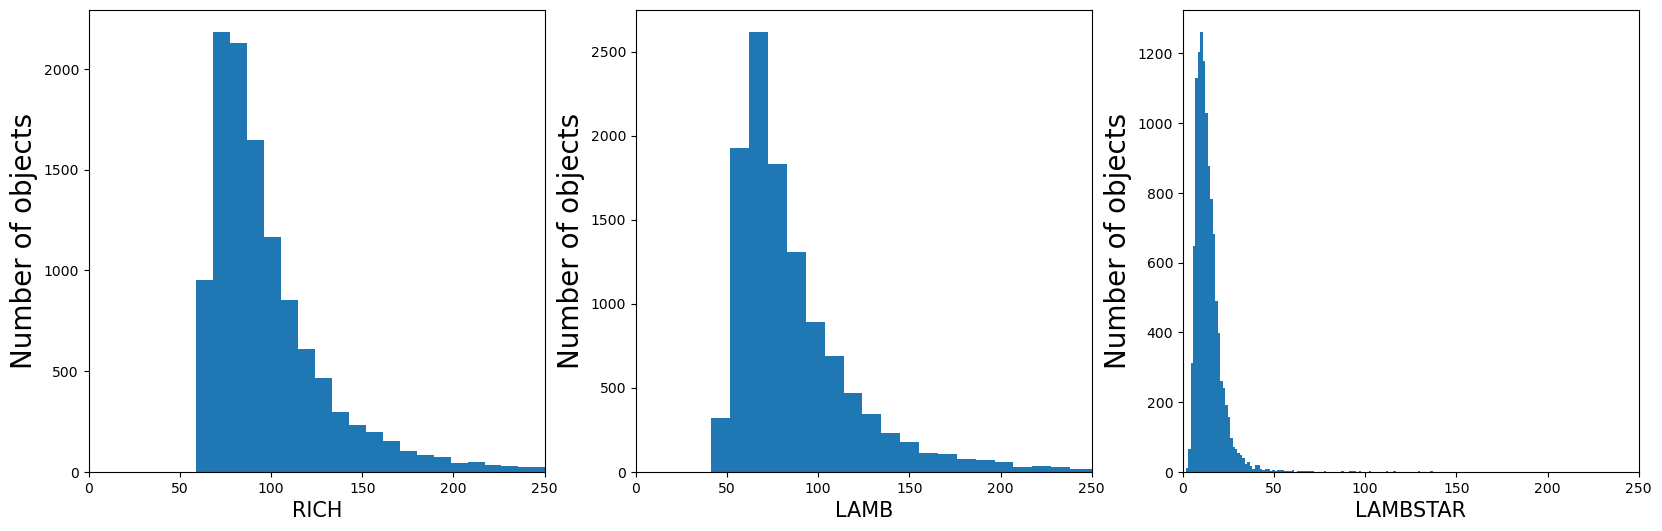

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,6))
def affiche(ax, param):
    ax.hist(amico_data[param], bins = 100)
    ax.set_xlim([0,250])
    ax.set_xlabel(param, fontsize = 15)
    ax.set_ylabel('Number of objects', fontsize = 20)
affiche(ax1, 'RICH') # apparent richness based on the filter formalism (visible number of galaxies)
affiche(ax2, 'LAMB') # apparent richness based on the galaxies probability assoc. (visible number of galaxies)
affiche(ax3, 'LAMBSTAR') # apparent richness based on m_star+1.5 (visible number of galaxies)
plt.show()

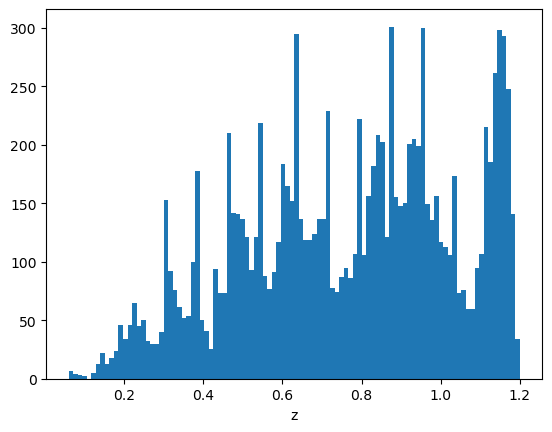

In [16]:
plt.hist(amico_data['Zphys'], bins = 100)
plt.xlabel('z')
plt.show()

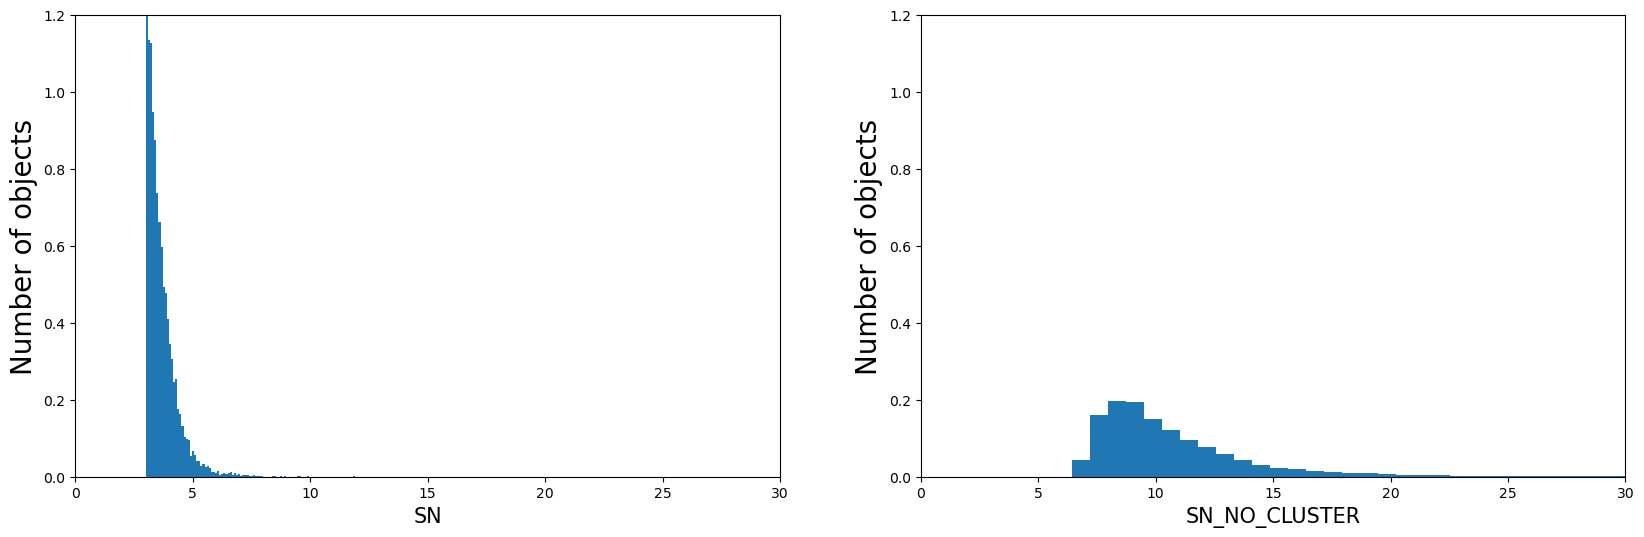

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6))
def affiche(ax, param):
    ax.hist(amico_data[param], bins = 100, density = True)
    ax.set_xlabel(param, fontsize = 15)
    ax.set_ylabel('Number of objects', fontsize = 20)
    ax.set_xlim([0,30])
    ax.set_ylim([0,1.2])
affiche(ax1, 'SN') #signal-to-noise ratio, r.m.s. including background and cluster contributions
affiche(ax2, 'SN_NO_CLUSTER') # signal-to-noise ratio, r.m.s. cluster contribution only
plt.show()

In [13]:
#track evolution of pz
mu_l = []
sig_l = []
pz_l = []
for i in range (119):
    pz_l.append(i)
    mu_l.append(np.mean(amico_data['Pz-{}'.format(i)]))
    sig_l.append(np.std(amico_data['Pz-{}'.format(i)]))
z_l = np.linspace(.015,1.95,119)

Text(0, 0.5, '$\\sigma$')

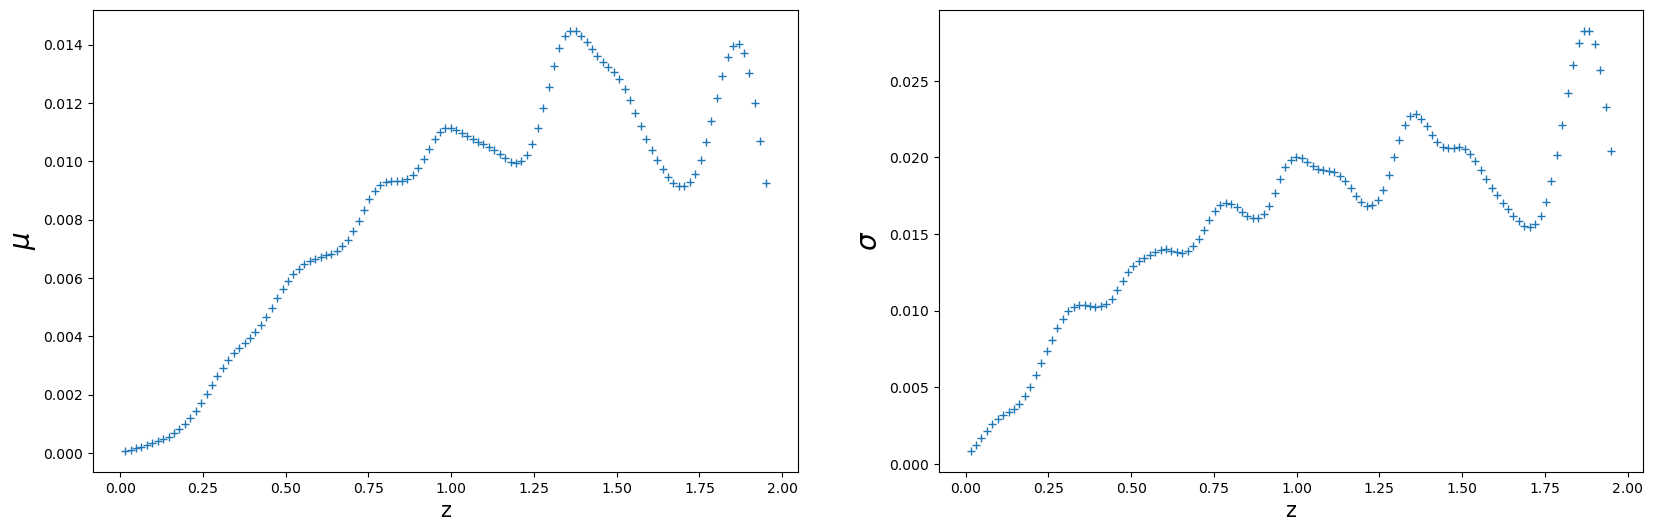

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6))
ax1.plot(z_l, mu_l, linestyle = 'none', marker = '+')
ax2.plot(z_l, sig_l, linestyle = 'none', marker = '+' )
ax1.set_xlabel('z', fontsize = 15)
ax2.set_xlabel('z', fontsize = 15)
ax1.set_ylabel('$\mu$', fontsize = 20)
ax2.set_ylabel('$\sigma$', fontsize = 20)

Text(0, 0.5, 'richness')

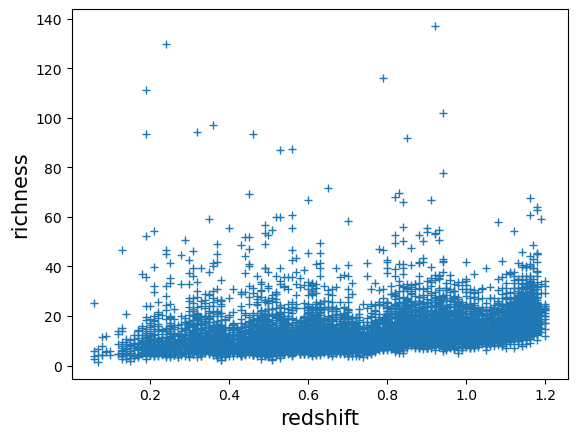

In [58]:
plt.errorbar(amico_data['Zphys'],amico_data['LAMBSTAR'], marker = '+', linestyle = 'None')
plt.xlabel('redshift', fontsize = 15)
plt.ylabel('richness', fontsize = 15)

In [ ]:
n_gal, zphys = np.histogram(amico_data['Zphys'], bins = 25)
density = n_gal/57.071968 #From text file found on gcr github check the one you can get from amico


In [86]:
dens_l = []
tshr_l = np.linspace(5,100,95)
for t in tshr_l :
    n_gal, zphys = np.histogram(amico_data[amico_data['LAMBSTAR']>t]['LAMBSTAR'])
    dens_l.append(np.sum(n_gal)/57.071968)


In [87]:
max(amico_data['LAMBSTAR'])

137.03265

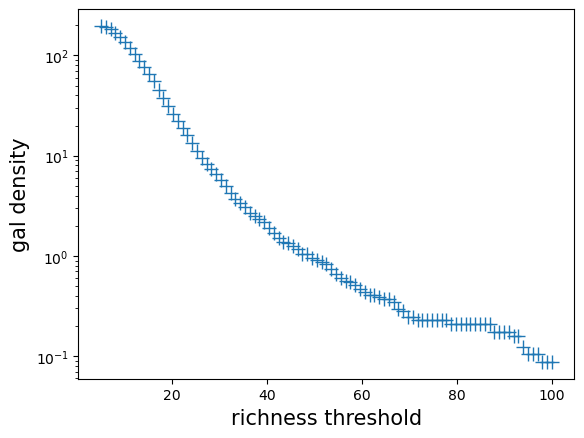

In [88]:
plt.errorbar(tshr_l, dens_l, marker = '+', linestyle = 'None', markersize = 10)
plt.xlabel('richness threshold', fontsize = 15)
plt.ylabel('gal density', fontsize = 15)
plt.yscale('log')

In [89]:
#For comparison w WAZP and redmapper

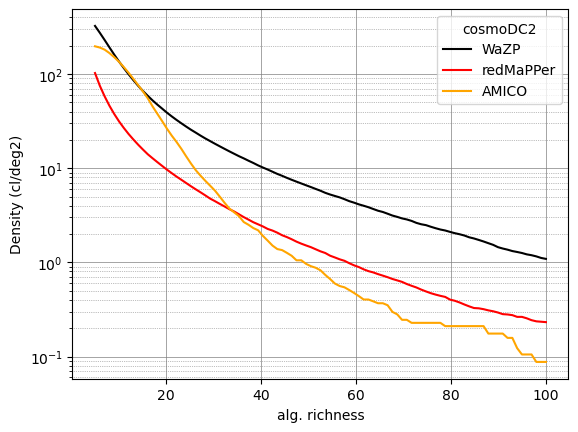

In [90]:
inpath = "/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/"
c1 = Table.read(inpath+'wazp/6980/Catalog.fits')
c2 = Table.read(inpath+'redmapper/full/cosmoDC2_v1.1.4_redmapper_v0.8.1/Catalog.fits')
c1=c1[c1['z']<1.15]
configuration = 'cosmoDC2'
label_1 = 'WaZP'
label_2 = 'redMaPPer'
label_3 = 'AMICO'
sky_area_sq_deg = 440
mag_bins = np.linspace(5, 100, 95)
cdf1 = np.searchsorted(c1["mass"], mag_bins, sorter=c1["mass"].argsort())
cdf1 = len(c1)-cdf1
cdf2 = np.searchsorted(c2["mass"], mag_bins, sorter=c2["mass"].argsort())
cdf2 = len(c2)-cdf2
g1, = plt.semilogy(mag_bins, cdf1 / sky_area_sq_deg, color = 'black')
g2, = plt.semilogy(mag_bins, cdf2 / sky_area_sq_deg, color = 'red')
g3, = plt.semilogy(tshr_l, dens_l, color = 'orange')
plt.xlabel("alg. richness");
plt.ylabel("Density (cl/deg2)");
#plt.legend([g1,g2,g3,g4],["dr6", "dr6 (truth_type=1)", "dr6 (truth_type=2)", "dr6 (ext=1)"], title = 'DC2 (9 tracts) / is_good_match', loc='upper left')
#plt.legend([g1,g2,g3],["dr6", "dr6 (truth_type=1)", "dr6 (truth_type!=1)"], title = 'DC2 (9 tracts) / is_good_match', loc='upper left')
plt.legend([g1,g2,g3],[label_1, label_2, label_3], title = 'cosmoDC2', loc='upper right')
plt.grid(which='major', axis='both', linestyle='-', linewidth='0.5', color='grey')
plt.grid(which='minor', axis='both', linestyle=':', linewidth='0.5', color='grey')